In [41]:
import os, io
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
import torchcde
from tensorboardX import SummaryWriter
writer = SummaryWriter('/work/hmzhao/embedding/img')


torch.random.manual_seed(42)
np.random.seed(42)

In [3]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-fixrho-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

# filter nan
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]>0)[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]<1)[0]
Y = Y[nanind]
X = X[nanind]

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
# Y = Y[:, 2:]
Y = Y[:, [2, 4, 5, 6, 7]]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 5
logsig = torchcde.logsig_windows(X, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

Shape of Y:  torch.Size([100000, 5])
normalized X mean: -1.1743464469848672
X std: 1.046597228312195


In [4]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_l32nG12diag.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
# model = CDE_MDN(input_dim, latent_dim, output_dim, 32).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [5]:
num = 4096 * 4
batchsize = 4096
n_gaussian = model.n_gaussian
latent_dim = model.latent_dim
features = torch.zeros((num, latent_dim))
model.eval()
model.output_feature = True
with torch.no_grad():
    for i in tqdm(range(int(np.ceil(num / batchsize)))):
        batch = coeffs[i*batchsize:min(i*batchsize+batchsize, num)].float().to(device)
        features[i*batchsize:min(i*batchsize+batchsize, num)] = model(batch).detach().cpu()

  0%|          | 0/4 [00:00<?, ?it/s]

In [80]:
imgs = np.zeros((num, 40, 40, 4))
for i in tqdm(range(num)):
    io_buf = io.BytesIO()
    fig, ax = plt.subplots(figsize=(4, 4), dpi=10)
    ax.axis('off')
    plt.xlim(-2, 2)
    ax.scatter(X[i, :, 0], X[i, :, 1], color='black')
    fig.savefig(io_buf, format='rgba', dpi=10)
    io_buf.seek(0)
    imgs[i] = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                        newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    io_buf.close()
    plt.close()

  0%|          | 0/16384 [00:00<?, ?it/s]

In [83]:
writer.add_embedding(features,
                     metadata=Y[:16384, 0].numpy(),
                     label_img=imgs[:, :, :, :-1].transpose(0, 3, 1, 2),)
writer.close()

In [81]:
np.save('/work/hmzhao/imgs.npy', imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


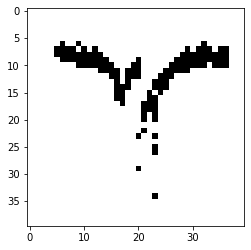

In [82]:
plt.imshow(imgs[0, :, :, :-1])

In [84]:
from sklearn.cluster import KMeans

In [90]:
kmeans = KMeans(n_clusters=8, random_state=0, max_iter=int(1e8)).fit(features)

In [91]:
kmeans.labels_

array([5, 5, 4, ..., 2, 3, 7], dtype=int32)

In [92]:
writer = SummaryWriter('/work/hmzhao/embedding/kmeans')
writer.add_embedding(features,
                     metadata=kmeans.labels_,
                     label_img=imgs[:, :, :, :-1].transpose(0, 3, 1, 2),)
writer.close()